## Data Preprocessing

In [62]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

IMG_SIZE = (64, 64)

def show(img):
    plt.imshow(img)
    plt.show()

def remove_lines(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([50, 50, 50])  # Adjust as needed based on line intensity
    mask = cv2.inRange(img, lower_black, upper_black)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return img_inpainted

def crop(img):
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV) 
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image

def segment_save(img, filename, destination_path):
    captcha_contents = filename.split('-')[0]
    chars = list(captcha_contents)
    for char in chars:
        class_path = os.path.join(destination_path, char)
        if not os.path.exists(class_path):
            os.makedirs(class_path)
    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    for i in range(num_portions):
        # Segment
        x_start = i * portion_width
        x_end = x_start + portion_width
        portion = img[:, x_start:x_end]

        # Resize (keras will do it for us apparently)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Threshold the image to make sure everything is black and white
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        char_filename = f"{chars[i]}/{chars[i]}_0.png"
        char_filepath = os.path.join(destination_path, char_filename)
        counter = 0
        while os.path.exists(char_filepath):
            char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            counter += 1
        cv2.imwrite(char_filepath, portion)

def print_char_stats(chars_path):
    classes = os.listdir(chars_path)

    # Initialize a counter to track the occurrences of each character
    character_counter = Counter()

    # Loop through each file in the folder
    for folder in classes:
        for char in folder:
            # Make sure the file is a valid image (you can adjust the file extension if needed)
            if char.endswith('.png'):
                # Extract the character label from the filename (assuming filename format like 'a_1.png')
                character_label = char.split('_')[0]  # Adjust based on your filename format

                # Update the counter with the extracted character label
                character_counter[character_label] += 1

    # Total number of characters (images)
    total_characters = sum(character_counter.values())

    # Number of unique classes (characters)
    num_classes = len(classes)

    # Print statistics
    print(f"Total number of characters: {total_characters}")
    print(f"Number of unique classes (characters): {num_classes}")
    print("\nCharacter distribution:")
    for character, count in character_counter.items():
        print(f"Character '{character}': {count} instances")
    
    return num_classes

In [63]:
folder_path = "./dataset/" #change this to your dataset folder
main_path = folder_path + "main/"
train_path = folder_path + "train/"
test_path = folder_path + "test/"
train_chars_path = folder_path + "train_chars/"
test_chars_path = folder_path + "test_chars/"

In [64]:
# # Segment captchas in training data and save to folder
# if not os.path.exists(train_chars_path):
#     os.makedirs(train_chars_path)

# data_files = os.listdir(train_path)
    
# for filename in data_files:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Print Stats
# num_classes = print_char_stats(train_chars_path)

# # Segment captchas in test data and save to folder
# if not os.path.exists(test_chars_path):
#     os.makedirs(test_chars_path)

# data_files = os.listdir(test_path)
    
# for filename in data_files:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)


## Augmenting Dataset

## Model

#### Initialise Model

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
# Init data
train_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # fill_mode='nearest',
    # width_shift_range=0.2, 
    # height_shift_range=0.2,
    # zoom_range=0.3
)

test_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

batch_size = 32

train_generator = train_data.flow_from_directory(
    train_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_data.flow_from_directory(
    test_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 70702 images belonging to 36 classes.
Found 12010 images belonging to 36 classes.


In [67]:
# Bare bones version
num_classes = 36
input_shape = (64, 64, 1)
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # 3rd Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 4th Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 5th Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 6th Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 7th Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    
    # Fully Connected Block
    Flatten(),

    Dense(512),
    LeakyReLU(alpha=0.25),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128),
    LeakyReLU(alpha=0.25),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_81 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 16, 16, 32)     │           12

 Total params: 1,308,484 (4.99 MB)

 Trainable params: 1,306,436 (4.98 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [43]:
# Load Model Weights from checkpoint


# num_classes = 36
# input_shape = (64, 64, 1)
# model = Sequential([
    
#     Conv2D(32, (3, 3), input_shape=(64, 64, 1)),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
    
#     # 2nd Convolutional Block
#     Conv2D(64, (3, 3)),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
    
#     # 3rd Convolutional Block
#     Conv2D(128, (3, 3)),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     # 4th Convolutional Block
#     Conv2D(128, (3, 3)),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
    
#     # Fully Connected Block
#     Flatten(),

#     Dense(512),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     Dropout(0.5),

#     Dense(128),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(),
#     Dropout(0.5),
    
#     Dense(num_classes, activation='softmax')
# ])

# model.load_weights('./checkpoints-4L-leaky128/epoch-35-val_loss-0.87.weights.h5')

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
# model.compile(
#     optimizer=optimizer, 
#     loss='categorical_crossentropy', 
#     metrics=['accuracy']
# )

#### Training Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_dir = "checkpoints-7L-64" # Ensure the checkpoints directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

class NFrequencyCheckpoint(ModelCheckpoint):
    def __init__(self, n, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n = n  # Frequency for saving checkpoints

    def on_epoch_end(self, epoch, logs=None):
        # Only save the checkpoint every n epochs
        if (epoch + 1) % self.n == 0:
            super().on_epoch_end(epoch, logs)

checkpoint_callback = NFrequencyCheckpoint(
    n=5,  # Save every 5 epochs
    filepath="checkpoints-7L-64/epoch-{epoch:02d}-val_loss-{val_loss:.2f}.weights.h5",
    save_weights_only=True,
    save_best_only=False,
    monitor="val_loss",
    mode="min",
    verbose=1
)

epochs = 100
history = model.fit(
    train_generator, 
    epochs=epochs, 
    validation_data=test_generator,
    callbacks=[checkpoint_callback, early_stopping],
)
model.save('captcha-model-7L-64.keras')
print("model saved!")

Epoch 1/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 424s 191ms/step - accuracy: 0.2438 - loss: 2.9371 - val_accuracy: 0.6329 - val_loss: 1.2803
Epoch 2/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 423s 191ms/step - accuracy: 0.5991 - loss: 1.4220 - val_accuracy: 0.6916 - val_loss: 1.0715
Epoch 3/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 450s 204ms/step - accuracy: 0.6483 - loss: 1.2269 - val_accuracy: 0.7263 - val_loss: 0.9716
Epoch 4/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 449s 203ms/step - accuracy: 0.6836 - loss: 1.1249 - val_accuracy: 0.7454 - val_loss: 0.8973
Epoch 5/100
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7040 - loss: 1.0538
Epoch 5: saving model to checkpoints-7L-64/epoch-05-val_loss-0.83.weights.h5
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 444s 201ms/step - accuracy: 0.7040 - loss: 1.0538 - val_accuracy: 0.7658 - val_loss: 0.8252
Epoch 6/100
  27/2210 ━━━━━━━━━━━━━━━━━━━━ 6:43 185ms/step - accuracy: 0.7438 - loss: 0.9173

KeyboardInterrupt: 

#### Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Add more eval metrics here: captcha accuracy


376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.7543 - loss: 0.8545
Test Accuracy: 75.60%


{'accuracy': [0.1894508748054504, 0.6125381941795349, 0.6421120920181274, 0.6638445558547974, 0.6847834644317627, 0.7114508748054504, 0.7255381941795349, 0.7381120920181274, 0.7448445558547974, 0.7537834644317627, 0.7606008052825928, 0.7661311030387878, 0.7720149159431458, 0.7762722373008728, 0.7809538841247559, 0.7839523553848267, 0.7896947860717773, 0.790232241153717, 0.7939521074295044, 0.7990297079086304, 0.8003168106079102, 0.8020848035812378, 0.8043902516365051, 0.8076150417327881, 0.8079544901847839, 0.8134423494338989, 0.8149415850639343, 0.8150264620780945, 0.8168792724609375, 0.8226500153541565, 0.8222256898880005, 0.8262566924095154, 0.8265961408615112, 0.8277276158332825, 0.8281802535057068, 0.8283641338348389, 0.8307402729988098, 0.8327204585075378, 0.834658145904541, 0.8322961330413818, 0.8370625972747803], 'loss': [1.4175164937973022, 1.2175164937973022, 1.1175164937973021, 1.0575164937973023, 1.0375164937973023, 1.0175164937973022, 0.9666697382926941, 0.9198397397994995

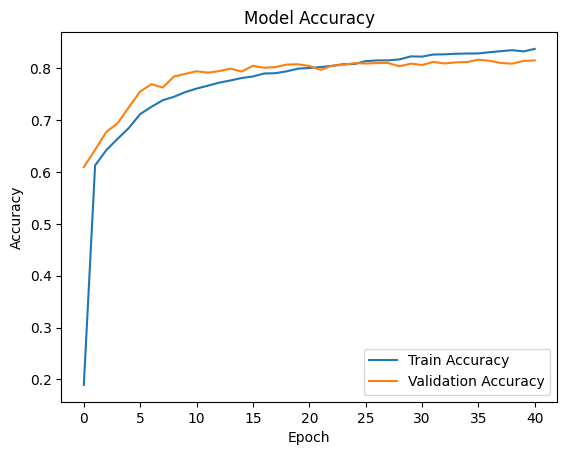

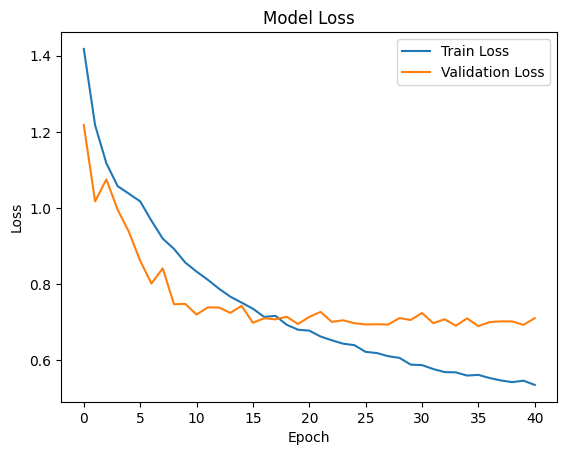

In [8]:
import matplotlib.pyplot as plt
import json

# Save the history to a JSON file
# with open('7L-large_history.json', 'w') as f:
#     json.dump(history, f, indent=4)

with open('7L-large_history.json', 'r') as f:
    history = json.load(f)

print(history)


# Plot training & validation accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [47]:
# Grad-CAM

